In [464]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

# Things to look at:
- Crop P vs crop Phi
- Plot psi ot D psi
  

In [535]:
def operators_ribbon(parameters):
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (normally we will want it to be one) 
    Ny = parameters['Ny']   # Number of unit cells in y direction
    kx = parameters['kx']
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Standard translations
        phase_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e]
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [1-(y//(Ny-1))] ################## Open boundaries in y direction. Does this matter?
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    
    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']
    for x in range(Nx):
        rotation = spin_rotation([x,0], theta, 0)
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
    for x in range(Nx):
        rotation = spin_rotation([x,Ny-1], pi-theta, pi)
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
    
    ####

    # # Now rotate the spins on the edge
    # theta = parameters['theta']
    # for x in range(Nx):
    #     rotation = spin_rotation([x,0], theta, 0)
    #     H = rotation.H@H@rotation
    #     Phi = rotation.H@Phi@rotation

    # for x in range(Nx):
    #     rotation = spin_rotation([x,1], theta, 0)
    #     H = rotation.H@H@rotation
    #     Phi = rotation.H@Phi@rotation
        
    # for x in range(Nx):
    #     rotation = spin_rotation([x,Ny-1], pi-theta, pi)
    #     H = rotation.H@H@rotation
    #     Phi = rotation.H@Phi@rotation

    # for x in range(Nx):
    #     rotation = spin_rotation([x,Ny-2], pi-theta, pi)
    #     H = rotation.H@H@rotation
    #     Phi = rotation.H@Phi@rotation
    
    # ####
    
    indices_to_delete = []#sites and spins on the edge. 
    
    for x in range(Nx):
        indices_to_delete.append(int(Nx*Ny + x)) #bottom edge
        indices_to_delete.append(int((Nx*Ny + Nx*(Ny-1) + x))) #top edge

    # for x in range(Nx):
    #     indices_to_delete.append(int(Nx*Ny + x)) #bottom edge
    #     indices_to_delete.append(int(x)) #bottom edge
    #     indices_to_delete.append(int(Nx*Ny + Nx + x)) #bottom edge
    #     indices_to_delete.append(int((Nx*Ny + Nx*(Ny-2) + x))) #top edge
    #     indices_to_delete.append(int((Nx*Ny + Nx*(Ny-1) + x))) #top edge
    #     indices_to_delete.append(int((Nx*(Ny-1) + x))) #top edge
        
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi
    
    return Phi, H, P, indices_to_delete

In [544]:
def operators_ribbon(parameters):
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (normally we will want it to be one) 
    Ny = parameters['Ny']   # Number of unit cells in y direction
    kx = parameters['kx']
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Standard translations
        phase_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e]
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [1-(y//(Ny-1))] ################## Open boundaries in y direction. Does this matter?
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")
    P = Phi.H@Phi
    
    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']

    for x in range(Nx):
        rotation = spin_rotation([x,2], theta, 0)
        H = rotation.H@H@rotation
        P = rotation.H@P@rotation
        Phi = rotation.H@Phi@rotation

    for x in range(Nx):
        rotation = spin_rotation([x,Ny-3], pi-theta, pi)
        H = rotation.H@H@rotation
        P = rotation.H@P@rotation
        Phi = rotation.H@Phi@rotation
    
    ####
    
    indices_to_delete = []#sites and spins on the edge. 


    for x in range(Nx):
        indices_to_delete.append(int(Nx*Ny + x)) #bottom edge
        indices_to_delete.append(int(x)) #bottom edge
        indices_to_delete.append(int(Nx*Ny + Nx*1 + x)) #bottom edge
        indices_to_delete.append(int(Nx*1 + x)) #bottom edge
        indices_to_delete.append(int(Nx*Ny + Nx*2 + x)) #bottom edge
        
        indices_to_delete.append(int(Nx*Ny + Nx*(Ny-1) + x)) #top edge
        indices_to_delete.append(int(Nx*(Ny-1) + x)) #top edge
        indices_to_delete.append(int(Nx*Ny + Nx*(Ny-2) + x)) #top edge
        indices_to_delete.append(int(Nx*(Ny-2) + x)) #top edge
        indices_to_delete.append(int(Nx*Ny + Nx*(Ny-3) + x)) #top edge
        
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    P_aux = P.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    P_aux = np.delete(P_aux, indices_to_delete, axis=0)
    P_aux = np.delete(P_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    P = csc_matrix(P_aux)
    Phi = csc_matrix(Phi_aux)
    P = (Phi.H)@Phi
    
    
    return Phi, H, P, indices_to_delete

In [536]:
i = 50 ### selected value of theta
Nx = 1
Ny = 18

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    theta = (pi/2)*(i/100),
    kx = 0,
)

Phi, H, P, indices_to_delete = operators_ribbon(parameters)

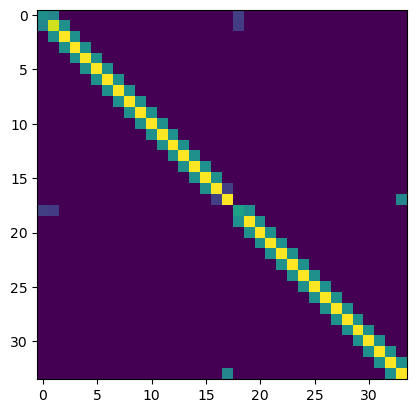

In [537]:
plt.imshow(np.abs(P.toarray()))

In [538]:
def make_bands_x(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem for all k
    for j, k in enumerate(momenta):
        parameters['kx'] = k
        Phi, H, P, indices_to_delete = operators_ribbon(parameters)
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-2, sigma = 0.001, which = 'LM',return_eigenvectors = False)

    return momenta, bands

In [539]:
i = 200 ### selected value of theta
Nx = 1
Ny = 20
nbands = 10

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    theta = (pi/2)*(i/100)
)

momenta, bands = make_bands_x(parameters,number_of_bands = nbands)

(-3.141592653589793, 3.141592653589793)

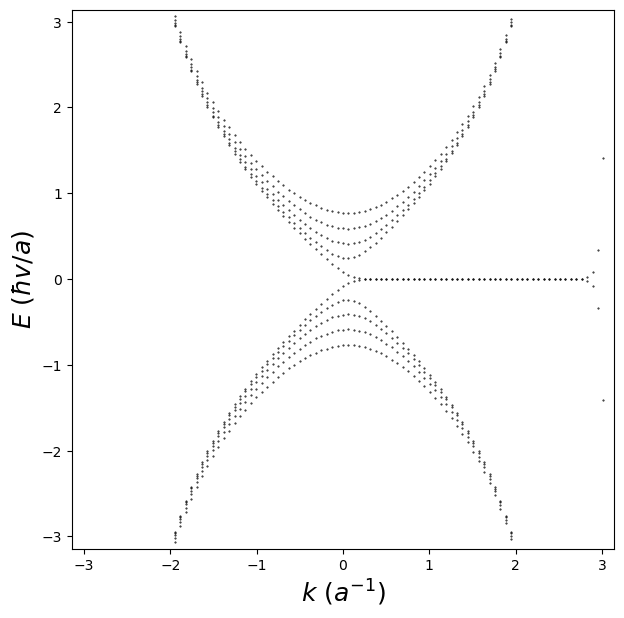

In [540]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.2)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(-pi,pi)
ax.set_xlim(-pi,pi)

# Now we want to plot eigenstates

In [541]:
i = 200 ### selected value of theta
Nx = 1
Ny = 80
nbands = 10

number_of_bands = nbands

kx = 0.5

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    theta = -(pi/2)*(i/100),
    kx = kx
)

Phi, H, P, deleted_indices = operators_ribbon(parameters)
eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-2, sigma = 0.001, which = 'LM',return_eigenvectors = True)

In [542]:
#Refill with zeros the deleted spins

states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
count = 0
for index in range(2*Nx*Ny):
    if index not in deleted_indices:
        states[index] = (Phi@eigenvectors)[index-count]
    else:
        count += 1

#Now make sure they are orthogonal
overlaps = states.conjugate().transpose()@states
##The overlap can only be non-zero for degenerate states
degenerate_indices = []
bulk_indices = []    
for i in range(overlaps.shape[0]):
    sorted = np.flip(np.sort(np.abs(overlaps[i])))
    if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
        bulk_indices.append(i)
    else:
        degenerate_indices.append(i)

overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

states_deg = np.delete(states, bulk_indices, axis=1)
states_bulk = np.delete(states, degenerate_indices, axis=1)

evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
states = orthogonal/norm[None,:]

# Rebuild state
def spin_rotation(site, theta, phi):
    'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
    rotation = np.identity(2*Nx*Ny, dtype = complex)
    
    spinup = int(site[0] + site[1]*Nx)
    spindown = int(site[0] + site[1]*Nx + Nx*Ny)
    
    rotation[spinup,spinup] = np.cos(theta/2)
    rotation[spinup,spindown] = np.sin(theta/2)
    rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
    rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
    
    return csc_matrix(rotation)


# Now rotate back the spins on the edge
theta = parameters['theta']

edge_points = np.concatenate((np.stack((np.arange(Nx),np.zeros(Nx))),np.stack((np.arange(Nx),(Ny-1)*np.ones(Nx)))), axis = 1)
boundary_spin_projections = np.concatenate((np.zeros(Nx), pi*np.ones(Nx)))

for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
    rotation = spin_rotation([point[0],point[1]], theta, point[2]+pi)
    states = rotation@states

chirality = scipy.sparse.kron(csc_matrix(sigma_z), np.identity(Nx*Ny), format = "csc")
save0 = (states[:,0]+chirality@states[:,0])/np.sqrt(2)
save1 = (states[:,0]-chirality@states[:,0])/np.sqrt(2)
states[:,0] = save0
states[:,1] = save1

###Now reshape
states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

### Now assign again energies
energies = np.zeros(number_of_bands)
for i in range(number_of_bands):
    if i in degenerate_indices:
        energies[i] = 0 #This should be zero
    else:
        energies[i] = eigenvalues[i]

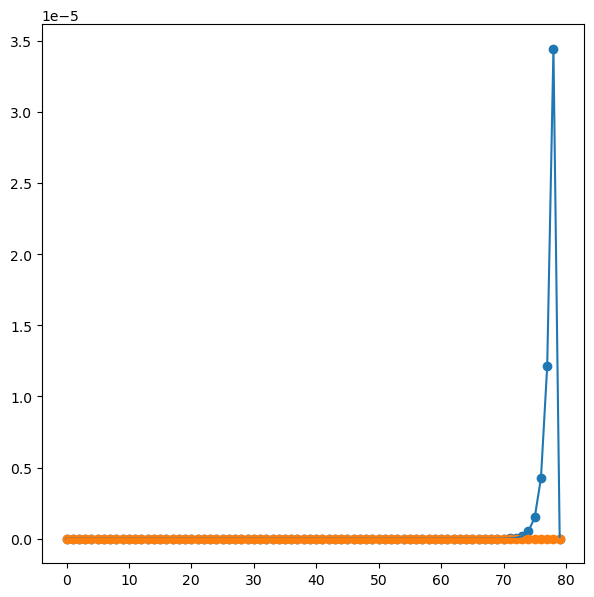

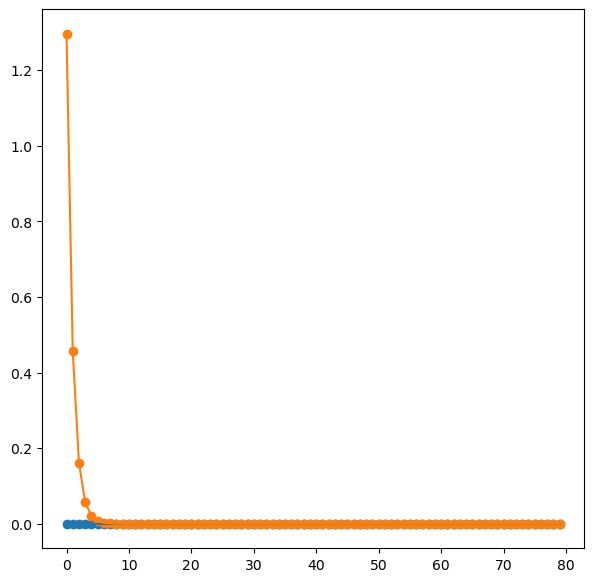

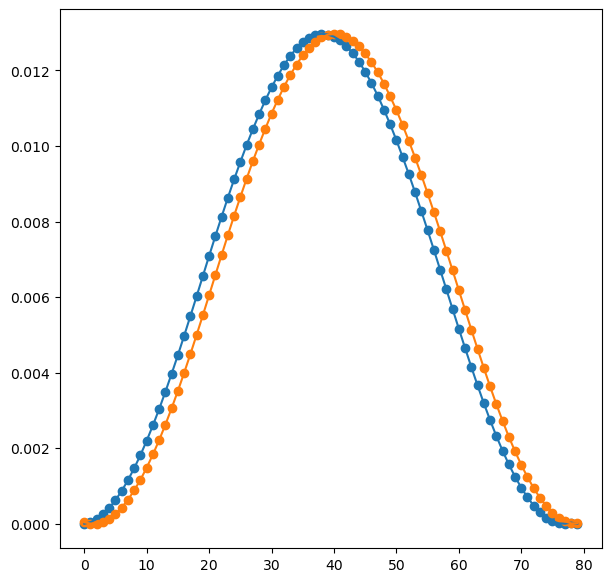

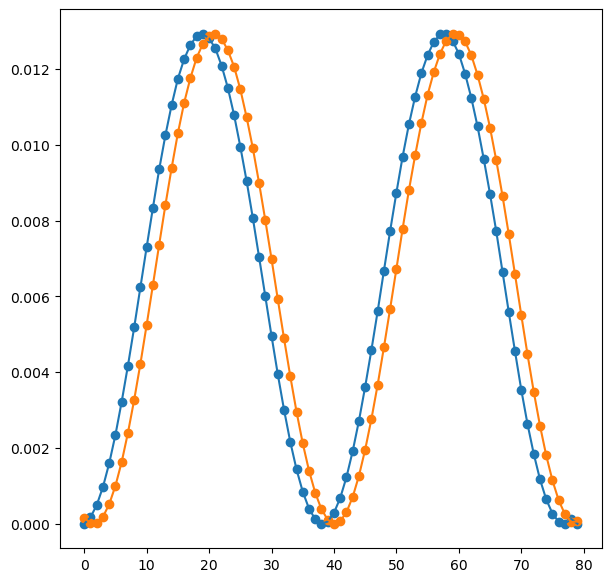

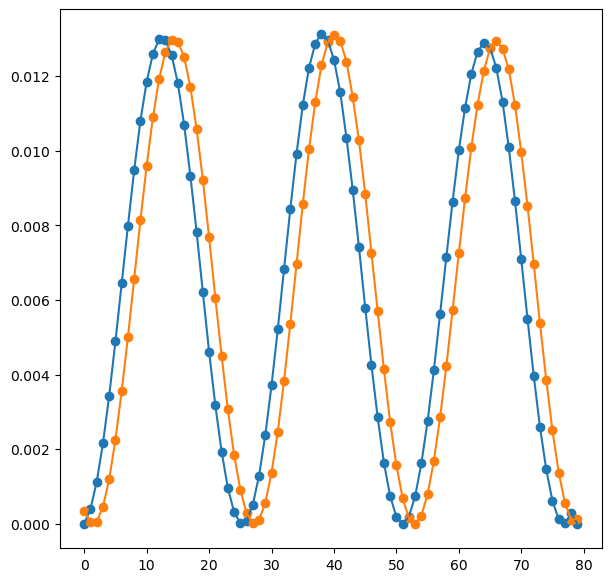

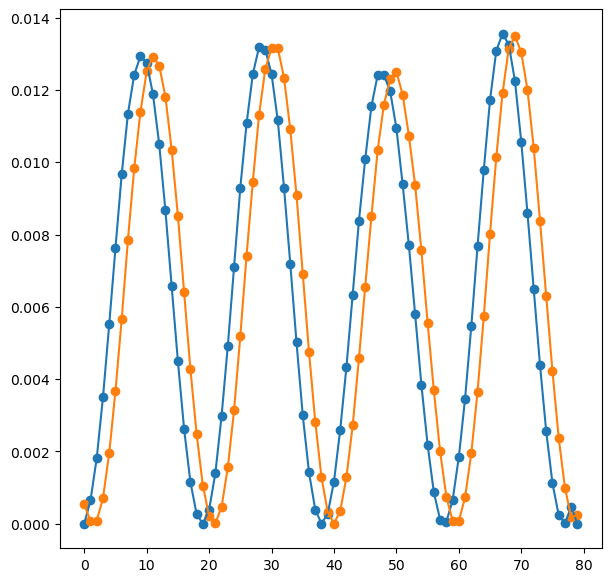

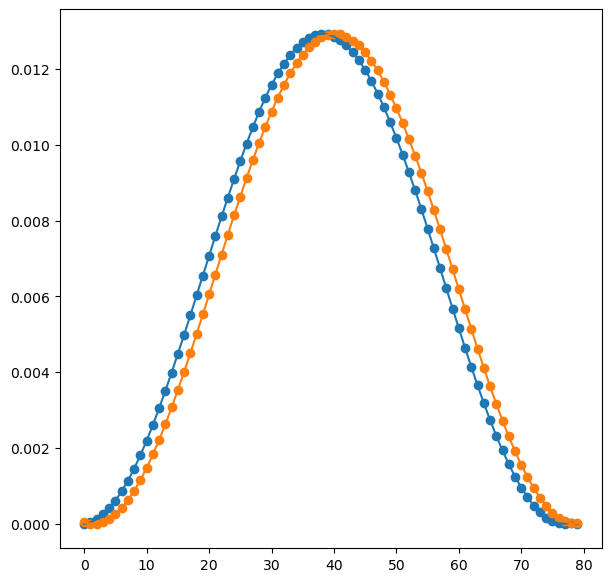

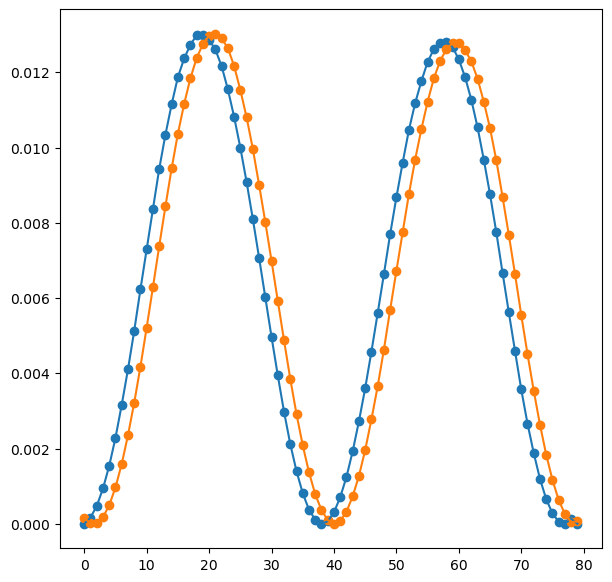

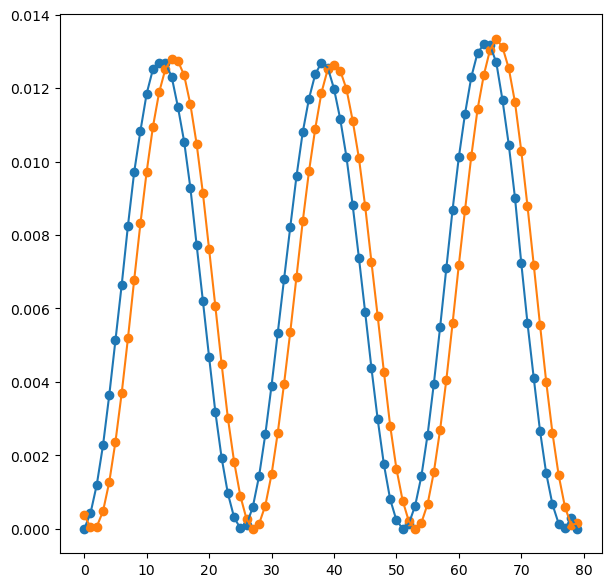

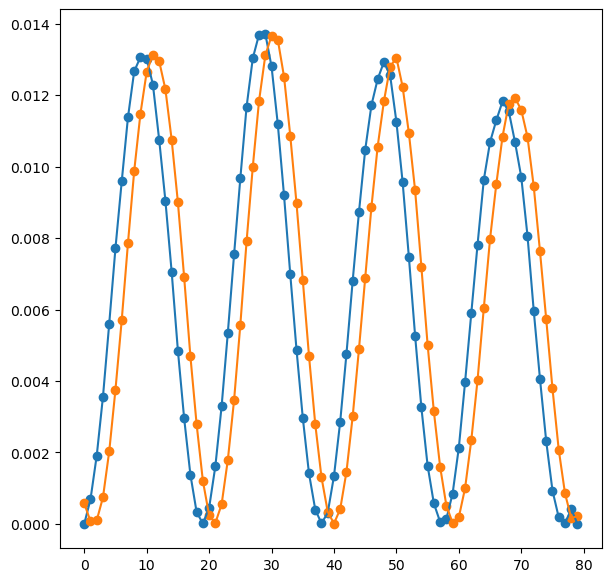

In [543]:
for i in range(nbands):
    probability_density  = np.sum(np.abs((states_shaped[i]))**2,axis = 0)
    spin_up_density  = np.abs((states_shaped[i,0]))**2
    spin_down_density  = np.abs((states_shaped[i,1]))**2    
    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(111)
    #ax.plot(np.arange(Ny),  probability_density)
    #ax.scatter(np.arange(Ny),  probability_density, c = "C0")
    ax.plot(np.arange(Ny),  spin_up_density, c = "C0")
    ax.scatter(np.arange(Ny),  spin_up_density, c = "C0")
    ax.plot(np.arange(Ny),  spin_down_density, c = "C1")
    ax.scatter(np.arange(Ny),  spin_down_density, c = "C1")
    #ax.imshow(probability_density,vmin = 0, origin = "lower")
    formatted_number = f"{energies[i]:.4e}"
    #print(formatted_number)
    #plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))